In [1]:
from modbampy import ModBam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def retrievePositionsDF(path):
    names=["chromosome", "chromStart", "chromEnd", "geneName", "POO"]
    positions_df = pd.read_csv(path, names=names, sep="\t")
    return positions_df


In [3]:
dmr_coords_path = './feature_references/fig6_features/mm39_dmr_coordinates.bed'

def retrievePositionsFromDF(df):
    dict_of_coordinates = {}
    for line, value in df.iterrows():
        index = value[3]
        sub_dict = {
            "chromosome" : value[0],
            "chromStart" : value[1],
            "chromEnd" : value[2],
            "geneName" : value[3]
        }
        coord_dict = {index : sub_dict}
        dict_of_coordinates.update(coord_dict)
    return dict_of_coordinates

coord_dict = retrievePositionsFromDF(retrievePositionsDF(dmr_coords_path))

In [4]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DMR_regions.bam') as bam: 
    gene_list = []
    for gene in coord_dict.values():
        read_list = []
        for read in bam.reads(gene["chromosome"], gene["chromStart"], gene["chromEnd"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [gene["chromosome"], gene["chromStart"], gene["chromEnd"], gene["geneName"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        gene_list.extend(read_list)
    names=["chromosome", "chromStart", "chromEnd", "geneName", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
    gene_df = pd.DataFrame(gene_list, columns=names)

In [5]:
def filterGeneStrands(all_imprinted_gene_df, gene): 
    
    gene_df = all_imprinted_gene_df.loc[(all_imprinted_gene_df["geneName"] == gene) & # filter to the gene
                                        (all_imprinted_gene_df["refPos"] >= all_imprinted_gene_df["chromStart"]) & # filter to gene coords
                                        (all_imprinted_gene_df["refPos"] <= all_imprinted_gene_df["chromEnd"])] 
    
    gene_df_pivot1 = gene_df.pivot(index=["chromosome", "chromStart", "chromEnd", "refStrand",  "geneName", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    gene_df_pivot1["c"] = 255 - gene_df_pivot1[["h", "m"]].sum(axis=1)
    gene_df_melt = pd.melt(gene_df_pivot1, ["chromosome", "chromStart", "chromEnd", "refStrand", "geneName", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    gene_df_melt = gene_df_melt.loc[gene_df_melt["score"] >= 0.66*255]
    gene_df_melt.loc[gene_df_melt["refStrand"] == "-", "refPos"] = gene_df_melt["refPos"].sub(1, axis=0)

    return gene_df_melt

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than 75% of CpGs
    return new_df


In [6]:
def makeHeatmap(gene):

    fig = plt.figure()

    data = NADropper(pivotToHeatmap(filterGeneStrands(gene_df, gene)))

    g = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Reds", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    g.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    g.ax_cbar.set_xticks([0.33, 1, 1.66])
    g.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    g.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    g.ax_heatmap.set_ylabel("Read")
    g.ax_heatmap.set_xlabel("CpG position")

    return 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

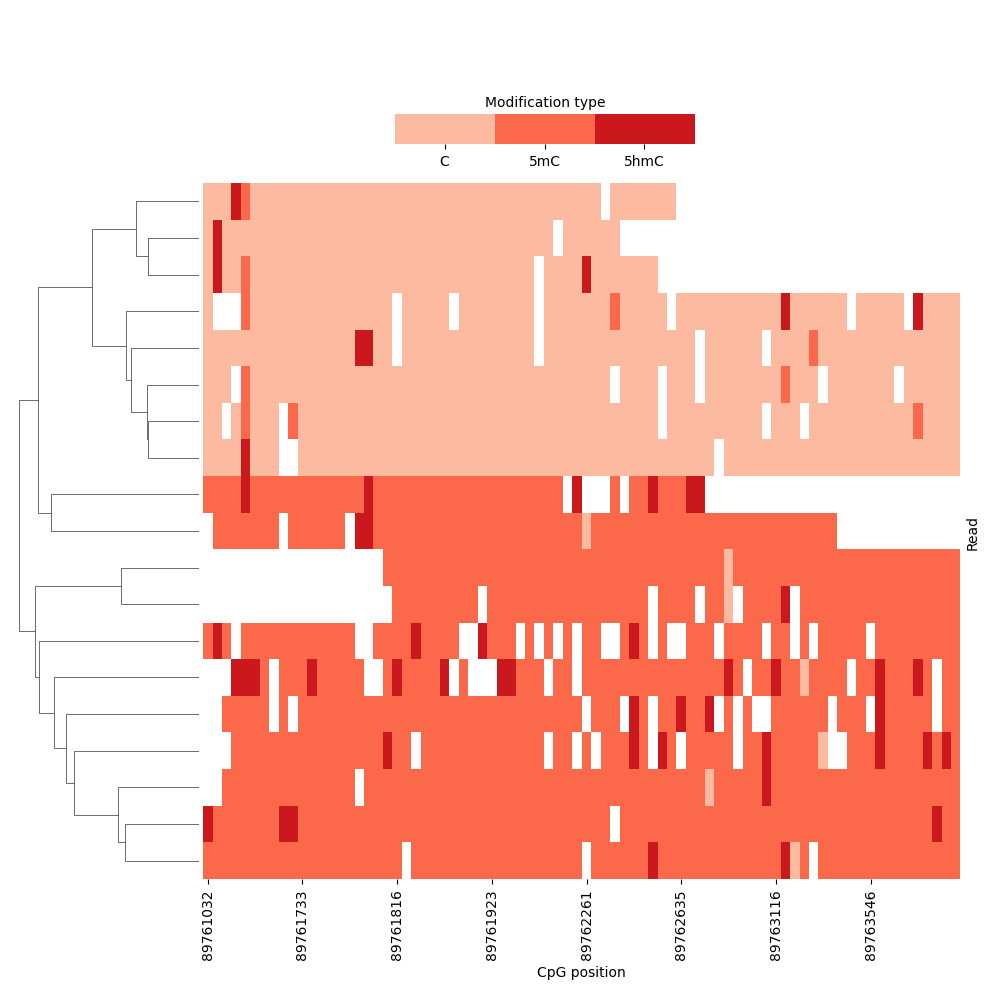

In [12]:
# It's also possible to revise the coordinates of DMRs
gene_df.loc[gene_df["geneName"] == "Dlk1-Gtl2", ["chromStart", "chromEnd"]] = 109493708, 109495485
gene_df.loc[gene_df["geneName"] == "Rasgrf1", ["chromStart", "chromEnd"]] = 89761022, 89763924

makeHeatmap("Dlk1-Gtl2")
plt.savefig("./plots/imprinted_genes/Dlk1-Gtl2_ALT_heatmap.png")
plt.close()
makeHeatmap("Rasgrf1")
plt.savefig("./plots/imprinted_genes/Rasgrf1_ALT_heatmap.png")

In [8]:
for name in gene_df["geneName"].value_counts().index:
    print("Making heatmap for {gene_name}".format(gene_name=name))
    makeHeatmap(name)
    plt.savefig("./plots/imprinted_genes/{gene_name}_heatmap.png".format(gene_name=name))
    plt.close()
    print("Saved heatmap for {gene_name}".format(gene_name=name))


Making heatmap for Gnas1A
Saved heatmap for Gnas1A
Making heatmap for Nespas-Gnasxl
Saved heatmap for Nespas-Gnasxl
Making heatmap for Mest
Saved heatmap for Mest
Making heatmap for Dlk1-Gtl2
Saved heatmap for Dlk1-Gtl2
Making heatmap for Grb10
Saved heatmap for Grb10
Making heatmap for H19
Saved heatmap for H19
Making heatmap for Rasgrf1
Saved heatmap for Rasgrf1
Making heatmap for Peg3
Saved heatmap for Peg3
Making heatmap for Impact
Saved heatmap for Impact
Making heatmap for Zac1
Saved heatmap for Zac1
Making heatmap for Igf2r
Saved heatmap for Igf2r
Making heatmap for Kcnq1ot1
Saved heatmap for Kcnq1ot1
Making heatmap for U2af1-rs1
Saved heatmap for U2af1-rs1
Making heatmap for Peg10
Saved heatmap for Peg10
Making heatmap for Snrpn
Saved heatmap for Snrpn


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>